In [1]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

/home/anton/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
image3 = load_image("/home/anton/Pictures/Screenshots/ARM.png")
image4 = load_image("/home/anton/Pictures/Screenshots/ARM2.png")

In [ ]:
import torch
torch.cuda.empty_cache()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load images
image1 = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")
image2 = load_image("https://huggingface.co/spaces/merve/chameleon-7b/resolve/main/bee.jpg")

# Initialize processor and model
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-256M-Instruct")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-256M-Instruct",
    torch_dtype=torch.float16,
    _attn_implementation="eager", #"flash_attention_2" if DEVICE == "cuda" else 
    # device_map="auto",
    # low_cpu_mem_usage=True,
).to(DEVICE)

In [ ]:
# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            # {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "Can you describe this image? Do you see the robot arm gripper and where? Give relative coords"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image4, image3], return_tensors="pt")
inputs = inputs.to(DEVICE)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])
# """
# Assistant: The first image shows a green statue of the Statue of Liberty standing on a stone pedestal in front of a body of water. 
# The statue is holding a torch in its right hand and a tablet in its left hand. The water is calm and there are no boats or other objects visible. 
# The sky is clear and there are no clouds. The second image shows a bee on a pink flower. 
# The bee is black and yellow and is collecting pollen from the flower. The flower is surrounded by green leaves.
# """

User:




Can you describe this image? Do you see the robot arm gripper and where? Give relative coords
Assistant: Yes, there is a robot arm gripper in the top right corner of the image.


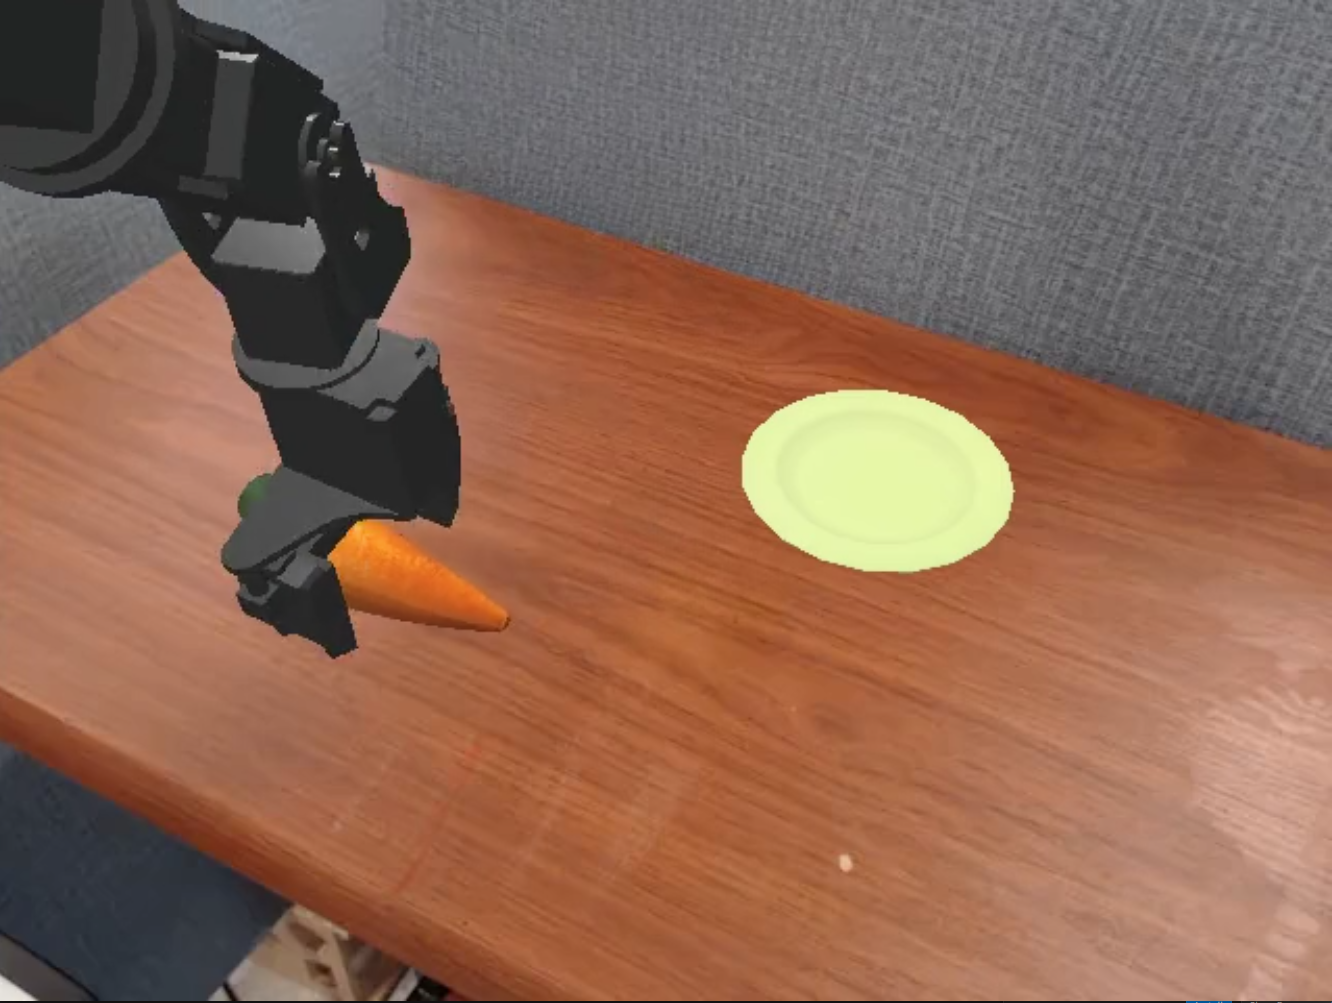

In [18]:
image4

In [ ]:
import numpy as np

# Загрузка массива
data = np.load("./RL4VLA/SimplerEnv/octo_collect/PutCarrotOnPlateInScene-v1/7/data/data_0000.npy", allow_pickle=True).item()

print(data.keys())          # Вывод массива в консоль
# print(data.shape)    # Размерность массива
img = data["image"][0]    # Тип данных


import matplotlib.pyplot as plt
for item in data["image"]:
    plt.imshow(item)
    plt.axis("off")  # убрать оси
    plt.show()



In [62]:
import numpy as np

data = np.load("./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/75/data/success_proc_0_numid_1_epsid_1.npz", allow_pickle=True)

data = data["arr_0"].item()

print(data.keys())

import pandas as pd

info_df = pd.DataFrame( [ data["info"][i].values() for i in range(len(data["info"])) ] )
info_df.columns = data["info"][0].keys()
info_df["action"] = [item for item in data["action"]]
print(data["action"][12])

info_df

# print(data["info"])

dict_keys(['is_image_encode', 'image', 'instruction', 'action', 'info'])
[ 0.00177675 -0.00115592 -0.03036611 -0.00600616  0.00812398 -0.02275613
  1.        ]


,elapsed_steps,is_src_obj_grasped,consecutive_grasp,src_on_target,gripper_carrot_dist,gripper_plate_dist,carrot_plate_dist,success,action
0,[33],[False],[False],[False],[0.18764913],[0.1841581],[0.122466415],[False],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,[33],[False],[False],[False],[0.18764569],[0.18415813],[0.122538336],[False],"[0.0010282397, 0.0025077134, -0.0016144961, -0..."
2,[33],[False],[False],[False],[0.18609361],[0.18292709],[0.12253983],[False],"[0.0033831894, 0.0074798157, -0.0048877597, -0..."
3,[33],[False],[False],[False],[0.18069322],[0.17878218],[0.12253983],[False],"[0.006665021, 0.012297409, -0.008314259, -0.00..."
4,[33],[False],[False],[False],[0.17032441],[0.17143515],[0.12253983],[False],"[0.011628211, 0.016721282, -0.012074865, -0.00..."
5,[33],[False],[False],[False],[0.15430248],[0.1618572],[0.12253983],[False],"[0.017675042, 0.018734053, -0.015193909, -0.00..."
6,[33],[False],[False],[False],[0.13343373],[0.1530979],[0.12253983],[False],"[0.017898202, 0.013848811, -0.0132286325, -0.0..."
7,[33],[False],[False],[False],[0.11323658],[0.14864004],[0.12253983],[False],"[0.014671236, 0.008602977, -0.009826995, -0.00..."
8,[33],[False],[False],[False],[0.09704929],[0.14811897],[0.12217968],[False],"[0.009493768, 0.0045106113, -0.006026052, -0.0..."
9,[33],[False],[False],[False],[0.08599085],[0.14909509],[0.12249783],[False],"[0.003275603, 0.0012824461, -0.001942113, -0.0..."


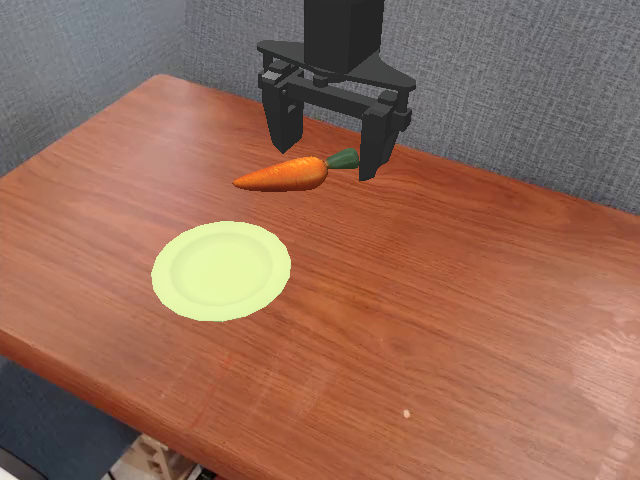

In [63]:
data["image"][0]